# Lens modeling with `lenstronomy`

GitHub page of `lenstronomy`: https://github.com/lenstronomy/lenstronomy

Documentation of `lenstronomy`: https://lenstronomy.readthedocs.io/en/latest/?badge=latest

Useful tutorials: https://github.com/lenstronomy/lenstronomy-tutorials 

In [1]:
# make sure lenstronomy is installed, otherwise install the latest pip version
try:
    import lenstronomy
except:
    !pip install lenstronomy

In [2]:
# import of standard python libraries
import numpy as np
import corner
import matplotlib.pyplot as plt

%matplotlib inline

## Load imaging data

The data and the PSF needs to be provided to `lenstronomy` using the
dictionaries `kwargs_data` and `kwargs_psf`.

In `kwargs_data`, we also need to proivde information on the noise level.
Either the pixel-wise noise map can be provided using the `noise_map`
keyword, or simply the `exposure_time` and `background_rms` can be provided
for `lenstronomy` to create the noise map by itself.

The keywords `ra_at_xy_0` and `dec_at_xy_0` are the RA and Declination in
arcsecond units at the (0, 0) pixel. The keyword `transform_pix2angle` is
the transformation matrix from pixel number coordinates to (RA, Decl.).
These keywords are used to convert pixel coordinates to RA and Decl.
coordinates. If you want to convert one 2D coordinate system to another, you
 will need to the offset between the zeropoints of two coordinate systems
 and transformation matrix that specifies the scaling and rotation of the
 axes. So, the keywords `ra_at_xy_0` and `dec_at_xy_0` specify the zeropoint
  offsets, and `transform_pix2angle` is the tansformation matrix specifying
  scaling and rotation.

For the first example of lensing data, no PSF was used to create the data.
Therefore, `psf_type` is set to `NONE`. For real data, there has to be a PSF
. We will work with PSFs in later examples.

In [3]:
import h5py

In [4]:
with h5py.File('./team_7_order_1.h5', 'r') as f:
    kwargs_data = {}
    for key in f:
        kwargs_data[key] = f[key][()]
        
kwargs_data

{'background_rms': 1.0,
 'dec_at_xy_0': -2.5,
 'exposure_time': array([[600., 600., 600., ..., 600., 600., 600.],
        [600., 600., 600., ..., 600., 600., 600.],
        [600., 600., 600., ..., 600., 600., 600.],
        ...,
        [600., 600., 600., ..., 600., 600., 600.],
        [600., 600., 600., ..., 600., 600., 600.],
        [600., 600., 600., ..., 600., 600., 600.]]),
 'image_data': array([[ 1.03524175, -0.64082584, -1.47638757, ...,  0.2566635 ,
         -1.26211907,  1.12324351],
        [-0.3604533 , -0.71306427, -1.18571592, ...,  0.80773681,
          0.15638371,  0.03279692],
        [ 0.56992024,  0.2489713 ,  0.91807352, ..., -0.27087028,
         -0.66841358, -1.27050781],
        ...,
        [ 0.15320153,  0.53997166,  0.15225182, ...,  0.79890636,
          1.38119862,  1.5943929 ],
        [ 1.73469589, -1.43705109, -0.75318786, ..., -0.95373261,
         -0.38856015,  0.43063936],
        [ 0.27830595, -1.73771859, -1.91817861, ...,  0.22774   ,
          0.2

In [5]:
with h5py.File('./psf.h5', 'r') as f:
    kwargs_psf = {}
    for key in f:
        kwargs_psf[key] = f[key][()]
        
kwargs_psf['psf_type'] = 'PIXEL'
kwargs_psf

{'kernel_point_source': array([[1.46714056e-05, 9.35287062e-06, 2.90359435e-06, ...,
         2.42407100e-06, 5.52120082e-06, 9.09519076e-06],
        [7.63451408e-06, 1.79611307e-05, 1.13368797e-05, ...,
         7.41443273e-06, 1.10966384e-05, 6.48436162e-06],
        [3.48301955e-06, 9.31257364e-06, 2.13260555e-05, ...,
         1.47811070e-05, 8.54394057e-06, 2.13203589e-06],
        ...,
        [2.49122672e-06, 7.95732376e-06, 1.58199546e-05, ...,
         2.12852956e-05, 1.07839660e-05, 2.27358305e-06],
        [5.68529549e-06, 1.20736895e-05, 9.14792508e-06, ...,
         8.90241972e-06, 1.71794072e-05, 8.37546668e-06],
        [9.16680983e-06, 6.76754098e-06, 2.43588875e-06, ...,
         2.81313487e-06, 6.95127665e-06, 1.37739089e-05]], dtype=float32),
 'psf_type': 'PIXEL'}

In [ ]:
image_data = np.loadtxt('team_7_order_1.txt')

background_rms = 1.
exposure_time = 600

ra_at_xy_0 = 2.5 # RA in arcsecond unit at (0, 0) pixel
dec_at_xy_0 = -2.5 # Declination in arcsecond unit at (0, 0) pixel
transform_pix2angle = np.array([[-0.05, 0.], [0., 0.05]]) # transformation
# matrix from pixel number coordinates to (RA, Decl.) coordinates

kwargs_data = {'image_data': image_data,
               'background_rms': background_rms,
               'noise_map': None,
               'exposure_time': exposure_time,
               'ra_at_xy_0': ra_at_xy_0,
               'dec_at_xy_0': dec_at_xy_0,
               'transform_pix2angle': transform_pix2angle
               }

kwargs_psf = {'psf_type': 'NONE', #"PIXEL",
              'kernel_point_source': None, #psf_map,
              }

<ipython-input-6-364b26a95dbf>:2: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(kwargs_data['image_data']), origin='lower', cmap='cubehelix');


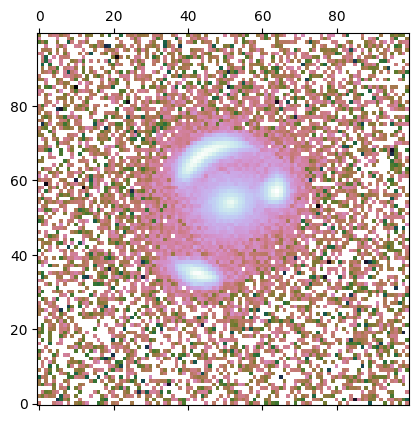

In [6]:
# extracting image_data from kwargs_data
plt.matshow(np.log10(kwargs_data['image_data']), origin='lower', cmap='cubehelix'); 

## Building a lens model

Here, we build a lens model. The lens model can be thought of three
components: the lens galaxy's mass model, the lens galaxy's light model, and
the source galaxy's light model. We have to give a list of profiles for each
 component as shown in the next codecell.

The `'EPL'` lens mass profile stands for Elliptical Power Law. The form of
this convergence profile is given by:
$$\kappa(x, y) = \frac{3 - \gamma}{2} \left[ \frac{\theta_{\rm E}}{\sqrt{q
x^2 + y^2 / q}} \right]^{\gamma - 1}. $$

The position angle $\phi$ adjusts the orientation of the mass profile's
major axis. The ellipticity parameters $q$ and $\phi$ can be reformulated as
$$e_1 = \frac{1 - q}{1 + q} \cos 2\phi,$$
$$e_2 = \frac{1 - q}{1 + q} \sin 2\phi.$$

`lenstronomy` uses $e_1$ and $e_2$ instead of $q$ and $\phi$, because $e_1$
and $e_2$ are easier to handle in numerical optimization, for example, in
MCMC. You can check [here](https://github.com/lenstronomy/lenstronomy-tutorials/blob/main/Notebooks/GettingStarted/units_coordinates_parameters_definitions.ipynb) for more details on
parameter definitions and conventions used in `lenstronomy`.


Both the lens galaxy's and the source galaxy's light profiles are modeled
with Sersic function, which is given by:

$$I(x, y) = I_{\rm e} \exp \left[ -b_{n} \left\{ \left( \frac{\sqrt{qx^2
+ y^2/q}}{R_{\rm Sersic}} \right)^{1/n_{\rm Sersic}} - 1 \right\}
\right].$$

In [7]:
lens_model_list = ['EPL', 'SHEAR']  # adding shear into lens_model_list
source_model_list = ['SERSIC_ELLIPSE', 'SHAPELETS']  # adding shapelets into source_model_list
lens_light_model_list = ['SERSIC_ELLIPSE']

In this cell below, we have to specify the initial values, upper and lower
limits for the model parameters specific to each of the model components
specified in the above lists. The `kwargs_*_sigma` dictionaries/lists are
used to set the initial size of the search area within particle swarm
optimization (PSO) or MCMC.

In [23]:
# lens galaxy's mass model
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

fixed_lens.append({}) 
fixed_lens.append({'ra_0': 0, 'dec_0': 0})
kwargs_lens_init.append({'theta_E': 1, 'gamma': 2., 'e1': 0., 'e2': 0.,
                         'center_x': 0., 'center_y': 0.}) 
kwargs_lens_init.append({'gamma1': 0, 'gamma2': 0, 'ra_0': 0, 'dec_0': 0})
kwargs_lens_sigma.append({'theta_E': 0.01, 'gamma': .1, 'e1': 0.05, 'e2': 0.05,
                         'center_x': 0.5, 'center_y': 0.5}) 
kwargs_lens_sigma.append({'gamma1': .01, 'gamma2': .01, 'ra_0': 0.01, 'dec_0': 0.01})
kwargs_lower_lens.append({'theta_E': 0.1, 'gamma': 1., 'e1': -0.5,
                          'e2': -0.5, 'center_x': -10, 'center_y': -10}) 
kwargs_lower_lens.append({'gamma1': -0.3, 'gamma2': -0.3, 'ra_0': -2, 'dec_0': -2})
kwargs_upper_lens.append({'theta_E': 5, 'gamma': 3., 'e1': 0.5, 'e2': 0.5,
                          'center_x': 10, 'center_y': 10}) 
kwargs_upper_lens.append({'gamma1': 0.3, 'gamma2': 0.3, 'ra_0': 2, 'dec_0': 2})


lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]


# lens galaxy's light model
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

fixed_lens_light.append({'n_sersic': 4.})
kwargs_lens_light_init.append({'R_sersic': 0.5, 'n_sersic': 2, 'e1': 0, 'e2': 0, 
                               'center_x': 0., 'center_y': 0, 'amp': 16})
kwargs_lens_light_sigma.append({'n_sersic': 1, 'R_sersic': 0.01, 'e1': 0.05, 'e2': 0.05,
                                'center_x': 0.1, 'center_y': 0.1, 'amp': 10})
kwargs_lower_lens_light.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5,
                                'center_x': -10, 'center_y': -10, 'amp': 0})
kwargs_upper_lens_light.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5.,
                                'center_x': 10, 'center_y': 10, 'amp': 100}) 

joint_lens_with_light = [[0, 0, ['center_x', 'center_y', 'e1', 'e2']]]

lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light,
                     kwargs_lower_lens_light, kwargs_upper_lens_light]


# source galaxy's light model
fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

fixed_source.append({'n_sersic': 1.}) 
fixed_source.append({'n_max': 5})
kwargs_source_init.append({'R_sersic': 0.2, 'n_sersic': 1, 'e1': 0, 'e2': 0,
                           'center_x': 0., 'center_y': 0, 'amp': 15}) 
kwargs_source_init.append({'beta': 15., 'n_max': 5, 'center_x': 0., 'center_y': 0.})
kwargs_source_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.01, 'e1': 0.05, 'e2': 0.05,
                            'center_x': 0.2, 'center_y': 0.2, 'amp': 10})
kwargs_source_sigma.append({'beta': 10, 'n_max': 0.1, 'center_x': 0.2, 'center_y': 0.2})
kwargs_lower_source.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5,
                            'center_x': -10, 'center_y': -10, 'amp': 0})
kwargs_lower_source.append({'beta': 0.01, 'n_max': 2, 'center_x': -10, 'center_y': -10})
kwargs_upper_source.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 3, 'n_sersic': 5.,
                            'center_x': 10, 'center_y': 10, 'amp': 100})
kwargs_upper_source.append({'beta': 100, 'n_max': 8, 'center_x': 10, 'center_y': 10})

source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source,
                 kwargs_lower_source, kwargs_upper_source]


# combining all the above specification in the `kwargs_params` dictionary
kwargs_params = {'lens_model': lens_params,
                 'source_model': source_params,
                 'lens_light_model': lens_light_params}

kwargs_constraints = {'joint_lens_with_light': joint_lens_with_light}

In [ ]:
print(kwargs_source_init)
print(fixed_source)
print(source_model_list)

[{'R_sersic': 0.2, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'n_max': 5, 'center_x': 0.0, 'center_y': 0, 'amp': 16, 'beta': 50.0}]
[{'n_sersic': 1.0, 'n_max': 5}]
['SERSIC_ELLIPSE', 'SHAPELETS']


#### Numerical settings

No need to change anything here for now. It's also fine to not
understand these settings for now.

In [17]:
kwargs_likelihood = {'check_bounds': True}

kwargs_numerics = {'supersampling_factor': 1,
                   'supersampling_convolution': False
                   }

#### Combining all the information to be sent to lenstronomy

In [18]:
kwargs_model = {'lens_model_list': lens_model_list,
                'source_light_model_list': source_model_list,
                'lens_light_model_list': lens_light_model_list}

multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]

kwargs_data_joint = {'multi_band_list': multi_band_list,
                     'multi_band_type': 'single-band'
                     # 'multi-linear': every imaging band has independent solutions 
                     # of the surface brightness, 'joint-linear': there is one joint 
                     # solution of the linear coefficients demanded across the bands.
                    }

## Here the model fiting is done

In [19]:
from lenstronomy.Workflow.fitting_sequence import FittingSequence


fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints,
                              kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 200, # using PSO
                                'n_iterations': 200}],
                       #['MCMC', {'n_burn': 200, 'n_run': 600, 'n_walkers':
                       # 200, 'sigma_scale': .1}]
                      ]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
Max iteration reached! Stopping.
-1.0908475261618007 reduced X^2 of best position
-5432.420680285767 log likelihood
9960 effective number of data points
[{'theta_E': 0.8086559905927868, 'gamma': 1.7951458977127392, 'e1': 0.12261073785872904, 'e2': -0.057030619634442926, 'center_x': -0.08032141388880341, 'center_y': 0.19418362416517113}, {'gamma1': -0.024422025018971796, 'gamma2': -0.08206403346363705, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.17988621941496188, 'n_sersic': 1.0, 'e1': 0.21271874616821237, 'e2': -0.34980776787703527, 'center_x': 0.17863414821534393, 'center_y': -1.100649748541262}, {'amp': 1, 'n_max': 5, 'beta': 0.027201906857338143, 'center_x': 0.028398827829824665, 'center_y': 0.08883844570337505}] source result
[{'amp': 1, 'R_sersic': 0.5003143791603497, 'n_sersic': 4.0, 'e1': 0.12261073785872904, 'e2': -0.057030619634442926, 'center_x': -0.0803214138888034

In [ ]:
from lenstronomy.Workflow.fitting_sequence import FittingSequence


fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [['MCMC', {'n_burn': 200, 'n_run': 600, 'n_walkers':  # using MCMC
                       200, 'sigma_scale': .1}],
        ]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [28:17<00:00,  2.12s/it]

Computing the MCMC...
Number of walkers =  200
Burn-in iterations:  200
Sampling iterations (in current run): 800
1699.0256834030151 time taken for MCMC sampling


## Visualizing the fitted model

-1.0864841360571533 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.0864841360571533


<ipython-input-22-51d71d795efa>:16: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


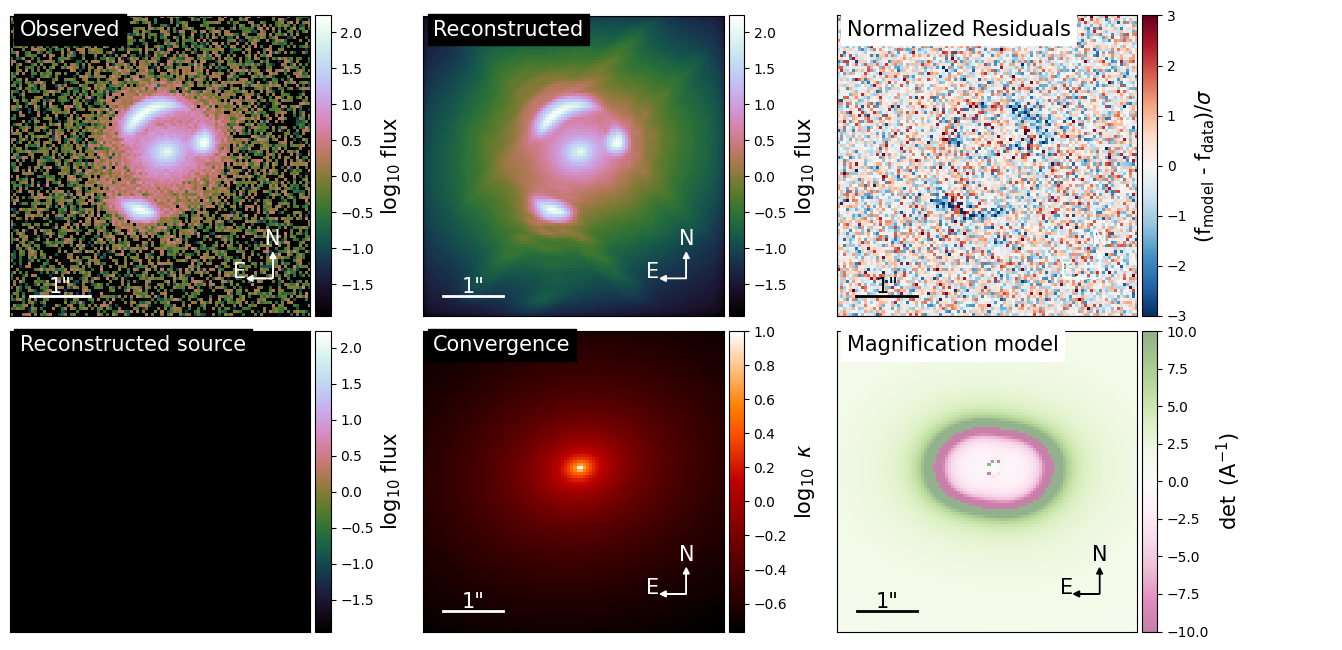

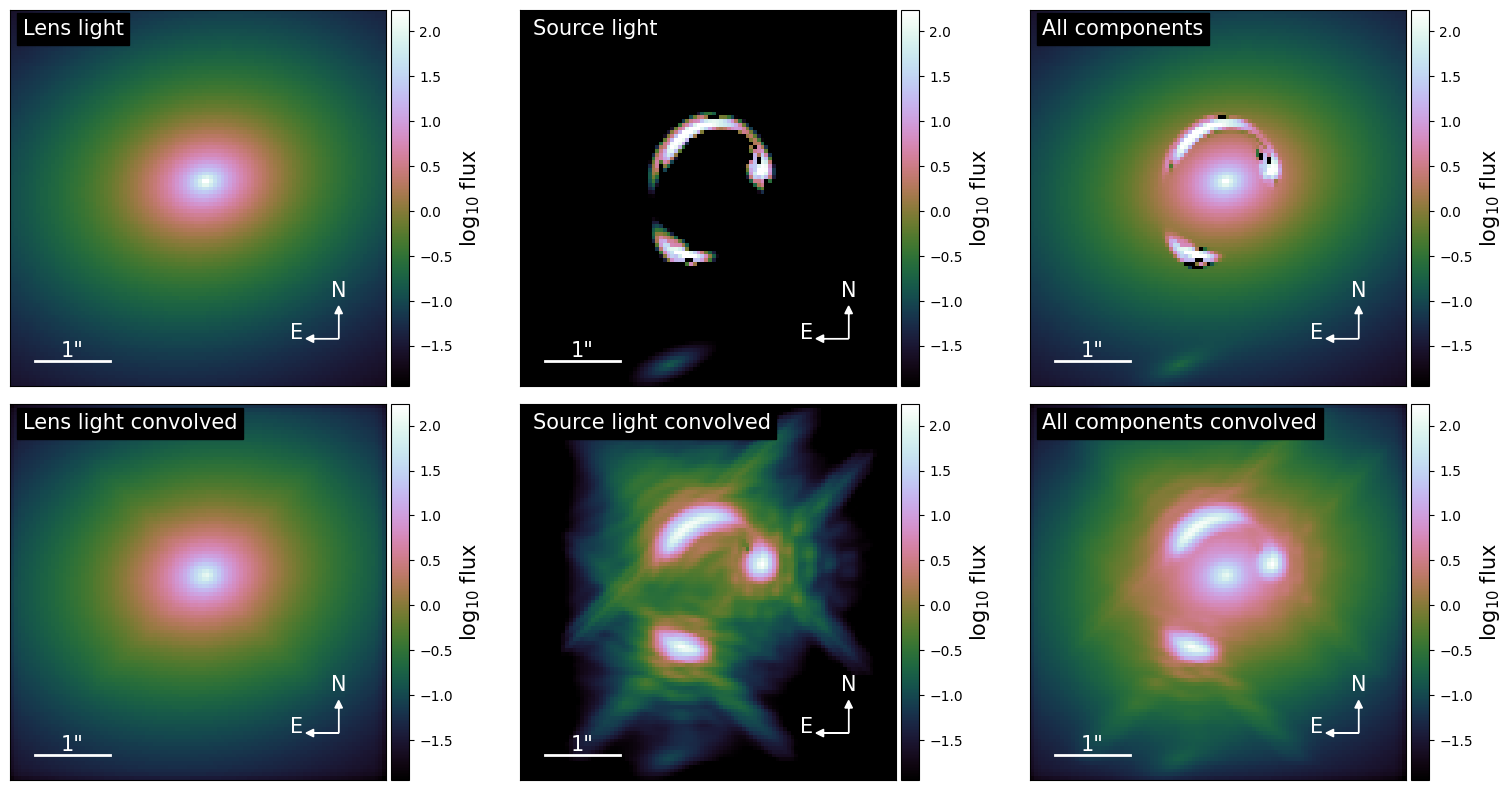

{'kwargs_lens': [{'theta_E': 0.8086559905927868, 'gamma': 1.7951458977127392, 'e1': 0.12261073785872904, 'e2': -0.057030619634442926, 'center_x': -0.08032141388880341, 'center_y': 0.19418362416517113}, {'gamma1': -0.024422025018971796, 'gamma2': -0.08206403346363705, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 1, 'R_sersic': 0.17988621941496188, 'n_sersic': 1.0, 'e1': 0.21271874616821237, 'e2': -0.34980776787703527, 'center_x': 0.17863414821534393, 'center_y': -1.100649748541262}, {'amp': 1, 'n_max': 5, 'beta': 0.027201906857338143, 'center_x': 0.028398827829824665, 'center_y': 0.08883844570337505}], 'kwargs_lens_light': [{'amp': 1, 'R_sersic': 0.5003143791603497, 'n_sersic': 4.0, 'e1': 0.12261073785872904, 'e2': -0.057030619634442926, 'center_x': -0.08032141388880341, 'center_y': 0.19418362416517113}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}


In [22]:
from lenstronomy.Plots.model_plot import ModelPlot

model_plot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02,
                      cmap_string="cubehelix",
                      )

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0,0])
model_plot.model_plot(ax=axes[0,1])
model_plot.normalized_residual_plot(ax=axes[0,2], v_min=-3, v_max=3,
                                   cmap='RdBu_r')
model_plot.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=100)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap='gist_heat')
model_plot.magnification_plot(ax=axes[1, 2], cmap='PiYG')
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(ax=axes[0,0], text='Lens light', lens_light_add=True, unconvolved=True)
model_plot.decomposition_plot(ax=axes[1,0], text='Lens light convolved', lens_light_add=True)
model_plot.decomposition_plot(ax=axes[0,1], text='Source light', source_add=True, unconvolved=True)
model_plot.decomposition_plot(ax=axes[1,1], text='Source light convolved', source_add=True)
model_plot.decomposition_plot(ax=axes[0,2], text='All components', source_add=True, lens_light_add=True, unconvolved=True)
model_plot.decomposition_plot(ax=axes[1,2], text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()
print(kwargs_result)

#### visualizing the MCMC chain, if run

In [ ]:
if len(chain_list) > 1:
    sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list[1]

    param_class = fitting_seq.param_class

    print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
    print("parameters in order: ", param_mcmc)
    print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0])
    n_sample = len(samples_mcmc)
    print(n_sample)
    samples_mcmc_cut = samples_mcmc[int(n_sample*1/2.):]
    if not samples_mcmc == []:
        n, num_param = np.shape(samples_mcmc_cut)
        plot = corner.corner(samples_mcmc_cut[:,:], labels=param_mcmc[:], show_titles=True)

In [ ]:
sampler_type,samples_mcmc, param_mcmc, dist_mcmc  = chain_list[0] # changing the above code a bit

param_class = fitting_seq.param_class

print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
print("parameters in order: ", param_mcmc)
print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0])
n_sample = len(samples_mcmc)
print(n_sample)
samples_mcmc_cut = samples_mcmc[int(n_sample*1/2.):]

if not samples_mcmc == []:
    n, num_param = np.shape(samples_mcmc_cut)
    plot = corner.corner(samples_mcmc_cut[:,:], labels=param_mcmc[:], show_titles=True)

number of non-linear parameters in the MCMC process:  3
parameters in order:  [[-334704.35424908315, -315797.04188092006, -296873.68307302566, -282972.9518354914, -263219.9436647286, -257582.0389328333, -246845.73954226647, -246845.73954226647, -245169.4353731467, -245169.4353731467, -245169.4353731467, -245169.4353731467, -240589.31530151193, -240589.31530151193, -226910.03297752293, -215930.59643079023, -209812.50048448556, -209812.50048448556, -207577.64652412903, -207577.64652412903, -203587.67977014638, -203587.67977014638, -203587.67977014638, -189847.35109815266, -189427.55548567348, -189427.55548567348, -189427.55548567348, -189427.55548567348, -189427.55548567348, -189427.55548567348, -172421.70735114528, -172421.70735114528, -172421.70735114528, -171782.05930939104, -171782.05930939104, -171782.05930939104, -171782.05930939104, -171782.05930939104, -171782.05930939104, -171782.05930939104, -171782.05930939104, -170274.88875119534, -170274.88875119534, -170274.88875119534, -16

IndexError: tuple index out of range